# Кибериммунная автономность$\\$Создание конструктивно защищённого автономного наземного транспортного средства$\\$Модуль 3

## О документе

Версия 1.03

Модуль 3 для регионального этапа соревнований по кибериммунной автономности

### Модуль 3. Внедрение блоков функциональной и информационной безопасности
#### Общая идея

Ключевая идея кибериммунной автономности заключается в том, чтобы уже на этапе проектирования внедрить защиту от кибератак как снаружи, так и изнутри - т.е. через уязвимые бортовые информационные системы. 
Мы исходим из того, что абсолютно защищённых систем не бывает, чем больше и сложнее код, тем проще одним ("плохим") в нём спрятать уязвимости, а другим ("хорошим", но уставшим) эти уязвимости не найти. 

Поэтому необходимо сделать так, чтобы наиболее критичный код был отделён от некритичного и протестирован особенно тщательно - таким образом можно снизить вероятность успешной атаки и затруднить задачу атакующим.

#### Цели и предположения безопасности

##### Цели безопасности
Устойчивость кибериммунных систем к атакам выражается в том, что поставленные заказчиком **цели безопасности** (ЦБ) не нарушаются даже в условиях кибератак (снаружи и изнутри).

Для наших автономных машинок заказчиком поставлены следующие ЦБ:

1. При любых обстоятельствах АНТС осуществляет перемещения в пределах заданных ограничений

2. При любых обстоятельствах АНТС выполняет только аутентичный (подлинный) маршрут

3. При любых обстоятельствах АНТС оставляет груз только в авторизованном пункте назначения

Ниже используется цифро-буквенное обозначение целей безопасности - например, ЦБ1 - первая цель безопасности из списка выше.

##### Предположения безопасности
При этом заказчик согласовал с разработчиками следующие **предположения безопасности** (ПБ) - утверждения о смежных системах, которые снимают с разработчиков часть задач для обеспечения целей безопасности:

1. При любых обстоятельствах только авторизованный персонал имеет физический доступ к критическим узлам АНТС

2. При любых обстоятельствах только аутентичные и авторизованные операторы имеют доступ к системе планирования заданий

3. Аутентичные и авторизованные операторы обладают необходимой квалификацией и являются благонадёжными (т.е. не пытаются намеренно причинить ущерб системе или третьим лицам, используя доступ к АНТС)

Ниже используется цифро-буквенное обозначение предположений безопасности - например, ПБ1 - первое предположение безопасности из списка выше.

### Киберпрепятствия

Прежде чем мы начнём внедрять механизмы безопасности, посмотрим, что произойдёт с нашей машинкой, если бортовые системы начнут вести себя не так, как мы ожидаем.

Для этого активируем специальный режим работы системы управления и снова запустим машинку по тому же маршруту, который был в конце модуля 2.

После инициализации системы управления добавьте следующую строку
```python
control_system.enable_surprises()
```

Но вначале нужно из модуля 2 скопировать сюда ваши текущие наработки, а именно ваши реализации классов коммуникационного шлюза (CommunicationGateway), систему навигации (NavigationSystem), управления (ControlSystem), также будем использовать маршрут, который вы создали.

In [19]:
# вставьте сюда ваш код
from src.control_system import BaseControlSystem
from src.config import SERVOS_QUEUE_NAME, CARGO_BAY_QUEUE_NAME
from src.navigation_system import BaseNavigationSystem
from multiprocessing import Queue
from src.communication_gateway import BaseCommunicationGateway
from src.config import CONTROL_SYSTEM_QUEUE_NAME
from src.event_types import Event


class CommunicationGateway(BaseCommunicationGateway):
    """CommunicationGateway класс для реализации логики взаимодействия
    с системой планирования заданий

    Работает в отдельном процессе, поэтому создаётся как наследник класса Process
    """
    def _send_mission_to_consumers(self):
        """ метод для отправки сообщения с маршрутным заданием в систему управления """

        # имена очередей блоков находятся в файле src/config.py
        # события нужно отправлять в соответствие с диаграммой информационных потоков
        control_q_name = CONTROL_SYSTEM_QUEUE_NAME

        # события передаются в виде экземпляров класса Event,
        # описание класса находится в файле src/event_types.py
        event = Event(source=BaseCommunicationGateway.event_source_name,
                      destination=control_q_name,
                      operation="set_mission", parameters=self._mission
                    )

        # поиск в каталоге нужной очереди (в данном случае - системы управления)
        control_q: Queue = self._queues_dir.get_queue(control_q_name)
        # отправка события в найденную очередь
        control_q.put(event)


class NavigationSystem(BaseNavigationSystem):
    """ класс навигационного блока """
    def _send_position_to_consumers(self):        
        control_q_name = CONTROL_SYSTEM_QUEUE_NAME # замените на правильное название очереди
        event = Event(source=self.event_source_name,
                            destination=control_q_name,
                            operation="position_update",
                            parameters=self._position) # замените на код создания сообщения с координатами для системы управления 
                     # подсказка, требуемая операция - position_update
        control_q: Queue = self._queues_dir.get_queue(control_q_name)
        control_q.put(event)


class ControlSystem(BaseControlSystem):
    """ControlSystem блок расчёта управления """

    def _send_speed_and_direction_to_consumers(self, speed, direction):
        servos_q_name = SERVOS_QUEUE_NAME
        servos_q: Queue = self._queues_dir.get_queue(servos_q_name)

        # инициализация сообщения с желаемой скоростью
        # подсказка: блок Приводы ожидает команду "set_speed" с параметром в виде скорости
        event_speed = Event(
            source=self.event_source_name,
            destination=servos_q_name,
            operation="set_speed",
            parameters=speed
        )

        # отправка сообщения с желаемым направлением
        # подсказка: блок Приводы ожидает команду "set_direction" с параметром в виде направления
        event_direction = Event(
            source=self.event_source_name,
            destination=servos_q_name,
            operation="set_direction",
            parameters=direction
        )

        servos_q.put(event_speed)
        servos_q.put(event_direction)

    def _lock_cargo(self):
        """ заблокировать грузовой отсек """
        cargo_q = self._queues_dir.get_queue(CARGO_BAY_QUEUE_NAME)
        # инициализация сообщения с командой на блокировку грузового отсека
        # подсказка: блок CargoBay ожидает команду "lock_cargo" без параметров
        event = Event(
            source=self.event_source_name,
            destination=CARGO_BAY_QUEUE_NAME,
            operation="lock_cargo",
            parameters=None
        )
        cargo_q.put(event)

    def _release_cargo(self):
        """ открыть грузовой отсек """
        cargo_q = self._queues_dir.get_queue(CARGO_BAY_QUEUE_NAME)
        # инициализация сообщения с командой на блокировку грузового отсека
        # подсказка: блок CargoBay ожидает команду "release_cargo" без параметров
        event = Event(
            source=self.event_source_name,
            destination=CARGO_BAY_QUEUE_NAME,
            operation="release_cargo",
            parameters=None
        )

        cargo_q.put(event)

Если у вас настроена и работает СУПА, установите в True значение переменной afcs_present

In [20]:
afcs_present = True

Поменяем идентификатор машинки для этого модуля

In [21]:
car_id = "m3"

In [22]:
# используем то же маршрутное задание, которое было в модуле 2
from time import sleep
from geopy import Point as GeoPoint


from src.queues_dir import QueuesDirectory
from src.servos import Servos
from src.sitl import SITL
from src.cargo_bay import CargoBay
from src.mission_planner import MissionPlanner
from src.config import LOG_ERROR, LOG_INFO
from src.mission_planner_mqtt import MissionSender
from src.mission_planner import Mission
from src.sitl_mqtt import TelemetrySender
from src.system_wrapper import SystemComponentsContainer
from src.wpl_parser import WPLParser


# возьмём маршрут из модуля 2
wpl_file = "module2.wpl"

parser = WPLParser(wpl_file)    
points = parser.parse()
print(points)

from src.mission_type import GeoSpecificSpeedLimit
speed_limits = [
    GeoSpecificSpeedLimit(0, 20),
    GeoSpecificSpeedLimit(9, 60),
    GeoSpecificSpeedLimit(11, 20),
    GeoSpecificSpeedLimit(13, 60),
]


home = points[0]
mission = Mission(home=home, waypoints=points,speed_limits=speed_limits, armed=True)

# каталог очередей для передачи сообщений между блоками
queues_dir = QueuesDirectory() 

if afcs_present:
    mission_sender = MissionSender(
        queues_dir=queues_dir, client_id=car_id, log_level=LOG_ERROR)
    telemetry_sender = TelemetrySender(
        queues_dir=queues_dir, client_id=car_id, log_level=LOG_ERROR)

mission_planner = MissionPlanner(
    queues_dir, afcs_present=afcs_present, mission=mission)

sitl = SITL(
    queues_dir=queues_dir, position=home,
    car_id=car_id, post_telemetry=afcs_present, log_level=LOG_ERROR)

communication_gateway = CommunicationGateway(
    queues_dir=queues_dir, log_level=LOG_ERROR)
control_system = ControlSystem(queues_dir=queues_dir, log_level=LOG_INFO)

navigation_system = NavigationSystem(
    queues_dir=queues_dir, log_level=LOG_ERROR)

servos = Servos(queues_dir=queues_dir, log_level=LOG_ERROR)
cargo_bay = CargoBay(queues_dir=queues_dir, log_level=LOG_INFO)

# по аналогии собираем все блоки в одном кузове
system_components = SystemComponentsContainer(
    components=[
        mission_sender,
        telemetry_sender,
        sitl,
        mission_planner,
        navigation_system,
        servos,
        cargo_bay,
        communication_gateway,
        control_system
    ] if afcs_present else [
        sitl,
        mission_planner,
        navigation_system,
        servos,
        cargo_bay,
        communication_gateway,
        control_system
    ])

#################################
# АКТИВАЦИЯ КИБЕРПРЕПЯТСТВИЙ
control_system.enable_surprises()
#################################

system_components.start()

# ограничение поездки по времени
# параметр sleep - время в секундах,
# настройте этот параметр так, чтобы ваша машинка завершила маршрут
# в случае превышения времени выполнения ячейки на более чем 10 секунд от заданного, 
# допустимо перезапустить вычислительное ядро и повторно выполнить весь блокнот, штрафные очки за это не начисляются
# при условии, что повторный запуск закончился успешно
sleep(30)

# останавливаем все компоненты
system_components.stop()

# удалим все созданные компоненты
system_components.clean()
del system_components

[Point(59.87469465702384, 29.82987105846405, 0.0), Point(59.87439849580289, 29.8298978805542, 0.0), Point(59.87411579399459, 29.82965111732483, 0.0), Point(59.87393809448474, 29.82915759086609, 0.0), Point(59.873900400527226, 29.828814268112183, 0.0), Point(59.873701160327556, 29.828798174858093, 0.0), Point(59.87368769810884, 29.82913613319397, 0.0), Point(59.87329998387079, 29.829452633857727, 0.0), Point(59.873219209502125, 29.82935070991516, 0.0), Point(59.87313843493723, 29.82938289642334, 0.0), Point(59.87211258089171, 29.829753041267395, 0.0), Point(59.87079857987126, 29.830214381217957, 0.0), Point(59.870793194514334, 29.831061959266663, 0.0), Point(59.870550852549975, 29.83111560344696, 0.0), Point(59.87047276420745, 29.829710125923157, 0.0), Point(59.870365055847884, 29.82886791229248, 0.0), Point(59.870206185380695, 29.828288555145264, 0.0), Point(59.86924217542263, 29.829200506210327, 0.0)]
[ИНФО][QUEUES] создан каталог очередей
[ИНФО][QUEUES] регистрируем очередь planner.m

Итак, в отличие от, надеемся, успешного завершения маршрута в модуле 2, сейчас ваша машинка ведёт себя совсем иначе. Например, она внезапно едет в совершенно другую сторону (это особенно хорошо видно при использовании СУПА). 
И это ещё не всё, что может пойти не так..

В этой реализации не очень много кода, теоретически, вы можете его весь изучить и устранить "незадокументированные возможности", однако в реальных системах кода гораздо больше. Например, кодовая база проекта с открытым исходным кодом ArduPilot, реализующего в том числе логику автопилота, составляет примерно миллион строк. 

Сколько времени вам понадобится, чтобы изучить и протестировать миллион строк кода? А ведь придётся проводить анализ и каждого обновления.. При этом неприятности могут быть хорошо спрятанными и на первый взгляд безобидными, вряд ли злоумышленники облегчат задачу и назовут свои изменения, например, "hacking_the_system" или "allowing_secret_remote_access". Вредоносный код может выглядеть совершенно безобидно или маскироваться под программный дефект.

Поэтому тщательный анализ потребует большого количества ресурсов (человеческих, вычислительных, временныз), что стоит дорого. 

Логичным выходом является выделение критичных для целей безопасности проверок в отдельный блок, который протестировать должно быть гораздо проще.

#### Задания 

В этом модуле задание будет состоять из двух частей разной сложности:

**3.1. добавить новый блок - "Ограничитель"** - этот модуль должен будет обеспечить соблюдение ограничений, указанных в маршрутном задании - это необходимо для обеспечения ЦБ1

**З.2. *(задание повышенной сложности)* добавить монитор безопасности (МБ)** - он должен контролировать все взаимодействия *бортовых систем* (т.е. не включая планировщик и симулятор) и не давать блокам взаимодействовать друг с другом непредусмотренным образом - например, блок №5 может принимать команды только от №3, попытка передать команду в №5 от №2 должна блокироваться нашим монитором безопасности - потенциально это необходимо для обеспечения всех ЦБ

Для выполнения первой части задачи 3.1. необходимо для начала изменить архитектуру АНТС как показано на рис. 5

![Архитектура системы с ограничителем](images/ciac-arch-m31.png)

Рис. 5. Архитектура АНТС с ограничителем (для ЦБ1)

Код базового класса Ограничителя находится в файле src/safety_block.py

По аналогии с заданием в модуле 1, необходимо создать на основе этого класса свой собственный под названием SafetyBlock, в котором реализовать передачу команд в приводы движения, только перед эти необходимо ещё и проконтролировать их безопасность.

Также необходимо реализовать передачу маршрутного задания из CommunicationGateway в SafetyBlock и координат из модуля Navigation в соответствии со стрелками на рис.5 выше.

Если всё сделано правильно, то Ограничителю будет известно следующее

- _mission - текущее маршрутное задание
- _position - текущие координаты

После проверки нужно установить значение внутренних переменных
- _speed - текущая (допустимая) скорость
- _direction - текущее (допустимое) направление

Желательно завершить следование по маршруту. В критической ситуации, если продолжение маршрута невозможно, следует установить значение скорости и направления в 0, после чего передать эти команды в блок приводов (Servos)

Базовый сценарий для новой архитектуры можно представить следующим образом (см. рис. 6)

![Базовый сценарий с блоком безопасности](images/basic-scenario-with-safety-block1.png)

Рис. 6. Базовый сценарий с блоком безопасности

Заготовка кода SafetyBlock

```python
class SafetyBlock(BaseSafetyBlock):
    """ класс ограничений безопасности """

    def _set_new_direction(self, direction: float):
        """ установка нового направления перемещения """
        self._log_message(LOG_INFO, f"текущие координаты: {self._position}")
        self._log_message(LOG_DEBUG, f"маршрутное задание: {self._mission}")
        self._log_message(LOG_DEBUG, f"состояние маршруте: {self._route}")
        # TODO реализовать контроль безопасности изменения направления
        self._direction = direction
        self._send_direction_to_consumers()

    def _set_new_speed(self, speed: float):
        """ установка новой скорости """
        # TODO реализовать контроль безопасности изменения скорости
        self._speed = speed
        self._send_speed_to_consumers()


    def _send_speed_to_consumers(self):
        self._log_message(LOG_DEBUG, "отправляем скорость получателям")
        servos_q_name = SERVOS_QUEUE_NAME
        servos_q: Queue = self._queues_dir.get_queue(servos_q_name)

        # отправка сообщения с желаемой скоростью
        event_speed = Event(source=self.event_source_name,
                            destination=servos_q_name,
                            operation="set_speed",
                            parameters=self._speed
                            )
        servos_q.put(event_speed)

    def _send_direction_to_consumers(self):
        self._log_message(LOG_DEBUG, "отправляем направление получателям")

        servos_q_name = SERVOS_QUEUE_NAME
        servos_q: Queue = self._queues_dir.get_queue(servos_q_name)

        # отправка сообщения с желаемой скоростью
        event_speed = Event(source=self.event_source_name,
                            destination=servos_q_name,
                            operation="set_direction",
                            parameters=self._direction
                            )
        servos_q.put(event_speed)
```

In [23]:
import math
from geopy import Point as GeoPoint
from multiprocessing import Queue
from src.event_types import Event
from src.security_monitory import BaseSecurityMonitor
from src.security_policy_type import SecurityPolicy
from src.control_system import BaseControlSystem
from src.navigation_system import BaseNavigationSystem
from src.communication_gateway import BaseCommunicationGateway
from src.safety_block import BaseSafetyBlock
from src.config import COMMUNICATION_GATEWAY_QUEUE_NAME, NAVIGATION_QUEUE_NAME, SAFETY_BLOCK_QUEUE_NAME, CONTROL_SYSTEM_QUEUE_NAME, SERVOS_QUEUE_NAME, CARGO_BAY_QUEUE_NAME
from src.config import LOG_ERROR, LOG_DEBUG, LOG_INFO, LOG_FAILURE

class SafetyBlock(BaseSafetyBlock):
    def _set_new_direction(self, direction: float):
        if not self._mission or not self._position or not self._route:
            self._log_message(LOG_ERROR, "Неизвестный маршрут")
            self._stop_afcs()
            return

        if not self._route.next_point():
            self._log_message(LOG_FAILURE, "Нет следующей точки маршрута.")
            self._stop_afcs()
            return

        next_direction = self._calculate_direction()
        error_direction = 1

        if (abs(next_direction - direction) > error_direction):
            self._log_message(LOG_ERROR, "Внештатное изменение направления движения.")

        self._direction = next_direction
        self._send_direction_to_consumers()

    def _set_new_speed(self, speed: float):
        """ установка новой скорости """
        if not self._mission or not self._position or not self._route:
            self._log_message(LOG_ERROR, "Неизвестный маршрут")
            self._stop_afcs()
            return

        allowed_speed = self._route.calculate_speed()
        if allowed_speed < speed:
            self._log_message(LOG_ERROR,
                              f"Внештатное превышение скорости: {speed}. Разрешенная скорость: {allowed_speed}")
            self._speed = allowed_speed
        else:
            self._speed = speed

        self._send_speed_to_consumers()

    def _calculate_direction(self):
        current_lattitude = math.radians(self._position.latitude)
        next_lattitude = math.radians(self._route.next_point().latitude)
        delta_longtitude = math.radians(self._route.next_point().longitude - self._position.longitude)

        x = math.sin(delta_longtitude) * math.cos(next_lattitude)
        y = math.cos(current_lattitude) * math.sin(next_lattitude) - \
            math.sin(current_lattitude) * math.cos(next_lattitude) * math.cos(delta_longtitude)

        return (math.degrees(math.atan2(x, y)) + 360) % 360

    def _calculate_distance(self, start: GeoPoint, end: GeoPoint) -> float:
        dx = end.latitude - start.latitude
        dy = end.longitude - start.longitude
        return math.hypot(dx, dy)

    def _send_speed_to_consumers(self):
        self._log_message(LOG_DEBUG, "отправляем скорость получателям")
        servos_q_name = SERVOS_QUEUE_NAME
        servos_q: Queue = self._queues_dir.get_queue(servos_q_name)
        event_speed = Event(source=self.event_source_name,
                            destination=servos_q_name,
                            operation="set_speed",
                            parameters=self._speed
                            )
        servos_q.put(event_speed)

    def _send_direction_to_consumers(self):
        self._log_message(LOG_DEBUG, "отправляем направление получателям")
        servos_q_name = SERVOS_QUEUE_NAME
        servos_q: Queue = self._queues_dir.get_queue(servos_q_name)
        event_speed = Event(source=self.event_source_name,
                            destination=servos_q_name,
                            operation="set_direction",
                            parameters=self._direction
                            )
        servos_q.put(event_speed)

    def _lock_cargo(self, _):
        self._log_message(LOG_INFO, "Блокировка грузового отсека.")
        self._send_lock_cargo_to_consumers()

    def _release_cargo(self, _):
        if not self._route.route_finished:
            self._log_message(LOG_FAILURE,
                              "АНТС не в конечной точке маршрута. Невозможно разблокировать грузовой отсек.")
            return
        self._send_release_cargo_to_consumers()

    def _send_lock_cargo_to_consumers(self):
        self._log_message(LOG_INFO, "Блокировка грузового отсека")
        cargo_q_name = CARGO_BAY_QUEUE_NAME
        cargo_q = self._queues_dir.get_queue(cargo_q_name)
        event = Event(
            source=self.event_source_name,
            destination=cargo_q_name,
            operation="lock_cargo",
            parameters=None
        )
        cargo_q.put(event)
    
    def _send_release_cargo_to_consumers(self):
        self._log_message(LOG_INFO, "Разблокировка грузового отсека")
        cargo_q_name = CARGO_BAY_QUEUE_NAME
        cargo_q = self._queues_dir.get_queue(cargo_q_name)
        event = Event(
            source=self.event_source_name,
            destination=cargo_q_name,
            operation="release_cargo",
            parameters=None
        )
        cargo_q.put(event)

    def _stop_afcs(self):
        self._direction = 0
        self._speed = 0
        self._log_message(LOG_FAILURE, "АНТС принудительно остановлено.")

In [24]:
# 2. напишите в этом блоке реализацию изменённых блоков связи, управления и навигации, 
# чтобы передавать данные согласно изменённой архитектуре на рис. 5 для обеспечения работы по сценарию на рис.6
# вставьте сюда ваш код
from src.control_system import BaseControlSystem
from src.config import SERVOS_QUEUE_NAME, CARGO_BAY_QUEUE_NAME
from src.navigation_system import BaseNavigationSystem
from multiprocessing import Queue
from src.communication_gateway import BaseCommunicationGateway
from src.config import CONTROL_SYSTEM_QUEUE_NAME
from src.event_types import Event


class CommunicationGateway(BaseCommunicationGateway):
    def _send_mission_to_consumers(self):
        control_q_name = CONTROL_SYSTEM_QUEUE_NAME
        safety_q_name = SAFETY_BLOCK_QUEUE_NAME
        event = Event(source=BaseCommunicationGateway.event_source_name,
                      destination=control_q_name,
                      operation="set_mission", parameters=self._mission
                      )
        safety_event = Event(source=BaseCommunicationGateway.event_source_name,
                             destination=safety_q_name,
                             operation="set_mission", parameters=self._mission
                             )
        control_q: Queue = self._queues_dir.get_queue(control_q_name)
        safety_q: Queue = self._queues_dir.get_queue(safety_q_name)
        control_q.put(event)
        safety_q.put(safety_event)


class NavigationSystem(BaseNavigationSystem):
    def _send_position_to_consumers(self):
        control_q_name = CONTROL_SYSTEM_QUEUE_NAME
        safety_q_name = SAFETY_BLOCK_QUEUE_NAME
        event = Event(source=self.event_source_name,
                      destination=control_q_name,
                      operation="position_update",
                      parameters=self._position)
        safety_event = Event(source=self.event_source_name,
                             destination=safety_q_name,
                             operation="position_update",
                             parameters=self._position
                             )
        control_q: Queue = self._queues_dir.get_queue(control_q_name)
        safety_q: Queue = self._queues_dir.get_queue(safety_q_name)
        control_q.put(event)
        safety_q.put(safety_event)


class ControlSystem(BaseControlSystem):
    def _send_speed_and_direction_to_consumers(self, speed, direction):
        safety_q_name = SAFETY_BLOCK_QUEUE_NAME
        safety_q: Queue = self._queues_dir.get_queue(safety_q_name)
        event_speed = Event(
            source=self.event_source_name,
            destination=safety_q_name,
            operation="set_speed",
            parameters=speed
        )
        event_direction = Event(
            source=self.event_source_name,
            destination=safety_q_name,
            operation="set_direction",
            parameters=direction
        )
        safety_q.put(event_speed)
        safety_q.put(event_direction)

    def _lock_cargo(self):
        safety_q_name = SAFETY_BLOCK_QUEUE_NAME
        safety_q = self._queues_dir.get_queue(safety_q_name)
        event = Event(
            source=self.event_source_name,
            destination=CARGO_BAY_QUEUE_NAME,
            operation="lock_cargo",
            parameters=None
        )
        safety_q.put(event)

    def _release_cargo(self):
        safety_q_name = SAFETY_BLOCK_QUEUE_NAME
        safety_q = self._queues_dir.get_queue(safety_q_name)
        event = Event(
            source=self.event_source_name,
            destination=CARGO_BAY_QUEUE_NAME,
            operation="release_cargo",
            parameters=None
        )
        safety_q.put(event)
# 3. создайте экземпляры изменённых классов и отправьте машинку по ранее предложенному маршруту
communication_gateway = CommunicationGateway(queues_dir=queues_dir, log_level=LOG_ERROR)
control_system = ControlSystem(queues_dir=queues_dir, log_level=LOG_INFO)
navigation_system = NavigationSystem(queues_dir=queues_dir, log_level=LOG_ERROR)

[ИНФО][QUEUES] регистрируем очередь communication
[ИНФО][QUEUES] регистрируем очередь control
[ИНФО][CONTROL] создана система управления
[ИНФО][QUEUES] регистрируем очередь navigation


In [25]:
# создадим все остальные компоненты

if afcs_present:
    mission_sender = MissionSender(
        queues_dir=queues_dir, client_id=car_id, log_level=LOG_ERROR)
    telemetry_sender = TelemetrySender(
        queues_dir=queues_dir, client_id=car_id, log_level=LOG_ERROR)

mission_planner = MissionPlanner(
    queues_dir, afcs_present=afcs_present, mission=mission)

sitl = SITL(
    queues_dir=queues_dir, position=home,
    car_id=car_id, post_telemetry=afcs_present, log_level=LOG_ERROR)

servos = Servos(queues_dir=queues_dir, log_level=LOG_ERROR)
cargo_bay = CargoBay(queues_dir=queues_dir, log_level=LOG_INFO)

safety_block = SafetyBlock(queues_dir=queues_dir, log_level=LOG_INFO)

[ИНФО][QUEUES] регистрируем очередь planner.mqtt
[ИНФО][QUEUES] регистрируем очередь sitl.mqtt
[ИНФО][QUEUES] регистрируем очередь planner
[ИНФО][MISSION PLANNER] создана система планирования заданий
[ИНФО][QUEUES] регистрируем очередь sitl
[ИНФО][QUEUES] регистрируем очередь servos
[ИНФО][QUEUES] регистрируем очередь cargo
[ИНФО][CARGO] создан компонент грузового отсека, отсек заблокирован
[ИНФО][QUEUES] регистрируем очередь safety
[ИНФО][SAFETY] создан ограничитель


In [26]:
# соберём все компоненты для запуска

# в зависимости от наличия СУПА используем разный набор компонентов - с передачей телеметрии или без

system_components = SystemComponentsContainer(
components=[
        # вариант компонентов с передачей телеметрии в СУПА
        mission_sender,
        telemetry_sender,
        sitl,
        mission_planner,
        navigation_system,
        servos,
        cargo_bay,
        communication_gateway,
        control_system,
        safety_block
    ] if afcs_present else [
        # вариант компонентов для конфигурации без СУПА
        sitl,
        mission_planner,
        navigation_system,
        servos,
        cargo_bay,
        communication_gateway,
        control_system,
        safety_block
    ])

#################################
# АКТИВАЦИЯ КИБЕРПРЕПЯТСТВИЙ
control_system.enable_surprises()
#################################

system_components.start()

# настройте этот параметр так, чтобы проверить работу ограничителя
sleep(120)

# останавливаем все компоненты
system_components.stop()

# удалим все созданные компоненты
system_components.clean()

[ИНФО][MISSION PLANNER] старт системы планирования заданий
[ИНФО][CARGO] старт блока грузового отсека[ИНФО][SAFETY] старт ограничителя

[ИНФО][CONTROL] старт системы управления


[ИНФО][MISSION PLANNER] запрошена новая задача, отправляем получателям
[ИНФО][MISSION PLANNER] новая задача отправлена в коммуникационный шлюз
[ИНФО][CONTROL] установлена новая задача, начинаем следовать по маршруту, текущее время 15:24:41.962137
[ИНФО][SAFETY] Блокировка грузового отсека.
[ИНФО][SAFETY] Блокировка грузового отсека
[ИНФО][CONTROL] новая скорость 20 (была 0)
[ИНФО][CONTROL] новое направление 177 (было 0)
[ИНФО][CARGO] заблокировать грузовой отсек
[ИНФО][CARGO] грузовой отсек заблокирован
[ИНФО][SAFETY] сегмент пройден
[ИНФО][CONTROL] сегмент пройден
[ИНФО][CONTROL] новое направление 21 (было 177)
[ОШИБКА][SAFETY] Внештатное изменение направления движения.
[ИНФО][CONTROL] новое направление 23 (было 21)
[ОШИБКА][SAFETY] Внештатное изменение направления движения.
[ИНФО][CONTROL] новое направление 25 (было 23)
[ОШИБКА][SAFETY] Внештатное изменение направления движения.
[ИНФО][CONTROL] новое направление 28 (было 25)
[ОШИБКА][SAFETY] Внештатное изменение направления движения.

#### Обеспечение ЦБ3: контроль доставки груза

С помощью логики ограничителя выше мы реализовали обеспечение ЦБ1 (соблюдение заданных ограничений), однако есть ещё ЦБ3 (отгрузка только в заданной точке), не говоря о ЦБ2 (следование только по аутентичному маршруту).

Для обеспечения ЦБ3 необходимо сделать следующее
1. изменить последовательность передачи команд, чтобы в блок управления грузовым отсеком (CargoBay) команды приходили только после проверки в Ограничителе
2. доработайте реализацию Ограничителя, чтобы команда на выгрузку передавалась в CargoBay только в конечной точке маршрута
3. продумайте логику работы блока безопасности, если система управления полностью перестанет работать (т.е. перестанет отправлять новые команды).

Изменённая архитектура приведена на рис. 7.

![Ограничитель для обеспечения ЦБ1 и ЦБ3](images/ciac-arch-m312.png)

Рис. 7. Ограничитель для обеспечения ЦБ1 и ЦБ3

In [11]:
# напишите свой код в этой ячейке, запустите машинку по маршруту, убедитесь, 
# что в конечной (и только в конечной!) точке CargoBay получает команду и успешно выполняет выгрузку
from src.control_system import BaseControlSystem
from src.config import SERVOS_QUEUE_NAME, CARGO_BAY_QUEUE_NAME
from src.navigation_system import BaseNavigationSystem
from multiprocessing import Queue
from src.communication_gateway import BaseCommunicationGateway
from src.config import CONTROL_SYSTEM_QUEUE_NAME
from src.event_types import Event
from src.safety_block import BaseSafetyBlock
from src.config import LOG_ERROR, LOG_DEBUG, LOG_INFO, SERVOS_QUEUE_NAME
import math
from geopy import Point as GeoPoint

class CommunicationGateway(BaseCommunicationGateway):
    """CommunicationGateway класс для реализации логики взаимодействия
    с системой планирования заданий

    Работает в отдельном процессе, поэтому создаётся как наследник класса Process
    """
    def _send_mission_to_consumers(self):
        """ метод для отправки сообщения с маршрутным заданием в систему управления """

        # имена очередей блоков находятся в файле src/config.py
        # события нужно отправлять в соответствие с диаграммой информационных потоков
        control_q_name = CONTROL_SYSTEM_QUEUE_NAME

        # события передаются в виде экземпляров класса Event,
        # описание класса находится в файле src/event_types.py
        event = Event(source=BaseCommunicationGateway.event_source_name,
                      destination=control_q_name,
                      operation="set_mission", parameters=self._mission
                    )

        # поиск в каталоге нужной очереди (в данном случае - системы управления)
        control_q: Queue = self._queues_dir.get_queue(control_q_name)
        # отправка события в найденную очередь
        control_q.put(event)


class NavigationSystem(BaseNavigationSystem):
    """ класс навигационного блока """
    def _send_position_to_consumers(self):        
        control_q_name = CONTROL_SYSTEM_QUEUE_NAME # замените на правильное название очереди
        event = Event(source=self.event_source_name,
                            destination=control_q_name,
                            operation="position_update",
                            parameters=self._position) # замените на код создания сообщения с координатами для системы управления 
                     # подсказка, требуемая операция - position_update
        control_q: Queue = self._queues_dir.get_queue(control_q_name)
        control_q.put(event)


class ControlSystem(BaseControlSystem):
    """ControlSystem блок расчёта управления """

    def _send_speed_and_direction_to_consumers(self, speed, direction):
        servos_q_name = SERVOS_QUEUE_NAME
        servos_q: Queue = self._queues_dir.get_queue(servos_q_name)

        # инициализация сообщения с желаемой скоростью
        # подсказка: блок Приводы ожидает команду "set_speed" с параметром в виде скорости
        event_speed = Event(
            source=self.event_source_name,
            destination=servos_q_name,
            operation="set_speed",
            parameters=speed
        )

        # отправка сообщения с желаемым направлением
        # подсказка: блок Приводы ожидает команду "set_direction" с параметром в виде направления
        event_direction = Event(
            source=self.event_source_name,
            destination=servos_q_name,
            operation="set_direction",
            parameters=direction
        )

        servos_q.put(event_speed)
        servos_q.put(event_direction)

    def _lock_cargo(self):
        """ заблокировать грузовой отсек """
        cargo_q = self._queues_dir.get_queue(CARGO_BAY_QUEUE_NAME)
        # инициализация сообщения с командой на блокировку грузового отсека
        # подсказка: блок CargoBay ожидает команду "lock_cargo" без параметров
        event = Event(
            source=self.event_source_name,
            destination=CARGO_BAY_QUEUE_NAME,
            operation="lock_cargo",
            parameters=None
        )
        cargo_q.put(event)

    def _release_cargo(self):
        """ открыть грузовой отсек """
        cargo_q = self._queues_dir.get_queue(CARGO_BAY_QUEUE_NAME)
        # инициализация сообщения с командой на блокировку грузового отсека
        # подсказка: блок CargoBay ожидает команду "release_cargo" без параметров
        event = Event(
            source=self.event_source_name,
            destination=CARGO_BAY_QUEUE_NAME,
            operation="release_cargo",
            parameters=None
        )

        cargo_q.put(event)

class SafetyBlock(BaseSafetyBlock):
    """ класс ограничений безопасности """

    def _set_new_direction(self, direction: float):
        """ установка нового направления перемещения """
        if not self._is_navigation_ready():
            self._handle_invalid_state()
            return

        next_point = self._route.next_point()
        if not next_point:
            self._log_message(LOG_INFO, "Маршрут завершён — останавливаться.")
            self._direction = direction
            self._send_direction_to_consumers()
            self._speed = 0
            self._send_speed_to_consumers()
            return

        calculated_bearing = self._calculate_bearing(self._position, next_point)
        diff = abs(calculated_bearing - direction)

        if diff > 10:
            self._log_message(LOG_ERROR, f"Коррекция курса: направление {direction}, корректное {calculated_bearing}")
        
        self._direction = calculated_bearing
        self._send_direction_to_consumers()

    def _set_new_speed(self, speed: float):
        """ установка новой скорости """
        if not self._is_navigation_ready():
            self._handle_invalid_state()
            return

        allowed_speed = self._route.calculate_speed()

        if self._reached_goal():
            self._log_message(LOG_INFO, "Цель достигнута — останавливаться.")
            self._speed = 0
        elif speed > allowed_speed:
            self._log_message(LOG_ERROR, f"Коррекция скорости: запрошено {speed}, разрешено {allowed_speed}")
            self._speed = allowed_speed
        else:
            self._speed = speed

        self._send_speed_to_consumers()

    def _calculate_bearing(self, start: GeoPoint, end: GeoPoint) -> float:
        """ Расчет азимута в градусах от точки start до точки end """
        delta_lon = end.longitude - start.longitude
        x = math.sin(math.radians(delta_lon)) * math.cos(math.radians(end.latitude))
        y = (math.cos(math.radians(start.latitude)) * math.sin(math.radians(end.latitude)) -
             math.sin(math.radians(start.latitude)) * math.cos(math.radians(end.latitude)) *
             math.cos(math.radians(delta_lon)))
        bearing = math.degrees(math.atan2(x, y))
        return (bearing + 360) % 360
    
    def _calculate_distance(self, start: GeoPoint, end: GeoPoint) -> float:
        """ Евклидово расстояние по координатам, можно заменить на geodesic() при необходимости """
        dx = end.latitude - start.latitude
        dy = end.longitude - start.longitude
        return math.hypot(dx, dy)

    def _send_speed_to_consumers(self):
        self._log_message(LOG_DEBUG, "отправляем скорость получателям")
        servos_q_name = SERVOS_QUEUE_NAME
        servos_q: Queue = self._queues_dir.get_queue(servos_q_name)

        # отправка сообщения с желаемой скоростью
        event_speed = Event(source=self.event_source_name,
                            destination=servos_q_name,
                            operation="set_speed",
                            parameters=self._speed
                            )
        servos_q.put(event_speed)

    def _send_direction_to_consumers(self):
        self._log_message(LOG_DEBUG, "отправляем направление получателям")

        servos_q_name = SERVOS_QUEUE_NAME
        servos_q: Queue = self._queues_dir.get_queue(servos_q_name)

        # отправка сообщения с желаемой скоростью
        event_speed = Event(source=self.event_source_name,
                            destination=servos_q_name,
                            operation="set_direction",
                            parameters=self._direction
                            )
        servos_q.put(event_speed)

communication_gateway = CommunicationGateway(queues_dir=queues_dir, log_level=LOG_ERROR)
control_system = ControlSystem(queues_dir=queues_dir, log_level=LOG_INFO)
navigation_system = NavigationSystem(queues_dir=queues_dir, log_level=LOG_ERROR)

[ИНФО][QUEUES] регистрируем очередь communication
[ИНФО][QUEUES] регистрируем очередь control
[ИНФО][CONTROL] создана система управления
[ИНФО][QUEUES] регистрируем очередь navigation


Работает
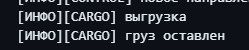

#### *Опциональное задание повышенной сложности* Обеспечение ЦБ2

**Перед началом работы над этой задачей рекомендуем сохранить все текущие изменения в git репозитории (git commit, git push).**

Напомним цель безопасности №2 (ЦБ2): "При любых обстоятельствах АНТС выполняет только аутентичный (подлинный) маршрут"

Обеспечение ЦБ2 потребует 
- внедрения механизма **контроля аутентичности маршрутного задания** (mission), а значит
- помимо изменения **блока безопасности** (SafetyBlock), модификации 
  - системы **планирования задания** (MissionPlanner)
  - **коммуникационного шлюза** (CommunicationGateway)
  - и, возможно, **системы управления** (ControlSystem). 
 
Для решения этой задачи допустимо менять код соответствующих модулей в папке src.

Возможным решением является внедрение механизма цифровой подписи, верификацией которой будет заниматься блок безопасности. В этой ситуации если коммуникационный шлюз (блок "1. Связь" на рис. 5 в модуле 1) оказался скомпрометированным и изменил маршрутное задание, оно не должно пройти проверку подлинности в блоке безопасности.

**Рекомендуем эту задачу делать в последнюю очередь**, *после успешного выполнения модуля 4*, поскольку успешное выполнение модуля 4 принесёт больше баллов, чем внедрение цифровой подписи и обеспечение ЦБ2. 
К сведению, реализованные в этой версии киберпрепятствия не предполагают компрометацию маршрутного задания.

Конечно, если будут решены все основные задачи и к тому же обеспечен контроль аутентичности маршрутного задания, такая работа с высокой вероятностью окажется лучшей.

In [14]:
# если вы собираетесь выполнить это задание, напишите в этой ячейке код выполнения изменённых блоков. 
# cам код допускается редактировать в папке src
# в случае успешной реализации машинка должна успешно пройти по маршруту, а в случае искажения маршрутного задания в блоке коммуникационного шлюза должна остаться на месте, 
# при этом именно блок безопасности должен заблокировать движение

### Задание 3.2. Монитор безопасности

В текущей реализации каждый блок сам решает куда и какие данные ему отправлять. Это приемлемо, когда каждый блок рассматривается как благонадёжный. Однако нельзя исключать ситуацию успешной компрометации какого-либо из блоков (одного или нескольких), в результате которой злоумышленник может получить полный контроль над частью системы. 

В такой ситуации необходимо выстроить внутреннюю "поверхность защиты", частью этой системы уже является блок "Ограничитель", однако необходимо сделать так, чтобы соответствующие запросы проходили только через него, а не в обход.

Для решения этой задачи необходимо добавить новый блок "Монитор безопасности". Его задача - обеспечить контроль направления информационных потоков, допустить передачу данных только между теми блоками и в тех направлениях, которые задуманы архитектором системы. Тогда, например, попытка передать команду из системы управления напрямую в сервоприводы в обход ограничителя будет заблокирована.

Возможно, возникнет вопрос, а что помешает злоумышленнику отправить команду в обход этого монитора безопасности. В рамках этой учебной инфраструктуры особо ничего, однако при разработке реальной системы можно использовать специализированные микроядерные операционные системы, такие как, например, KasperskyOS, которые обеспечат обязательное вовлечение монитора безопасности в контроль взаимодействия между блоками.

Архитектура системы для решения задачи 3.2 должна выглядеть как на рис.8:

![Архитектура системы с монитором безопасности](images/ciac-arch-m32.png)

Рис. 8. Архитектура бортовых систем с монитором безопасности

Базовый класс модуля безопасности находится в файле src/security_monitor.py, его менять не нужно. 

В следующей ячейке находится реализация класса SecurityMonitor

In [12]:
from src.security_monitory import BaseSecurityMonitor
from src.security_policy_type import SecurityPolicy

from src.config import COMMUNICATION_GATEWAY_QUEUE_NAME, LOG_DEBUG, LOG_ERROR, LOG_INFO
    
    
class SecurityMonitor(BaseSecurityMonitor):
    """ класс монитора безопасности """

    def __init__(self, queues_dir):
        super().__init__(queues_dir)
        self._init_set_security_policies()

    def _init_set_security_policies(self):
        """ инициализация политик безопасности """
        default_policies = [
            SecurityPolicy(
                source=COMMUNICATION_GATEWAY_QUEUE_NAME,
                destination=CONTROL_SYSTEM_QUEUE_NAME,
                operation='set_mission')
        ]
        self.set_security_policies(policies=default_policies)        

    def set_security_policies(self, policies):
        """ установка новых политик безопасности """
        self._security_policies = policies
        self._log_message(
            LOG_INFO, f"изменение политик безопасности: {policies}")

    def _check_event(self, event: Event):
        """ проверка входящих событий """
        self._log_message(
            LOG_DEBUG, f"проверка события {event}, по умолчанию выполнение запрещено")

        authorized = False
        request = SecurityPolicy(
            source=event.source,
            destination=event.destination,
            operation=event.operation)

        if request in self._security_policies:
            self._log_message(
                LOG_DEBUG, "событие разрешено политиками, выполняем")
            authorized = True

        if authorized is False:
            self._log_message(LOG_ERROR, f"событие не разрешено политиками безопасности! {event}")
        return authorized

Обратите внимание на этот код:
```python
    def _init_set_security_policies(self):
        """ инициализация политик безопасности """
        default_policies = [
            SecurityPolicy(
                source=COMMUNICATION_GATEWAY_QUEUE_NAME,
                destination=CONTROL_SYSTEM_QUEUE_NAME,
                operation='set_mission')
        ]
        self.set_security_policies(policies=default_policies)  
```

В нём инициализируется политика безопасности, разрешающая запрос set_mission от коммуникационного шлюза в систему управления.

Код политики безопасности в строка 6-9:
```python
SecurityPolicy(
                source=COMMUNICATION_GATEWAY_QUEUE_NAME,
                destination=CONTROL_SYSTEM_QUEUE_NAME,
                operation='set_mission')
```

Шаблон политики безопасности описан в файле src/security_policy_type.py:
```python
@dataclass
class SecurityPolicy:
    """ политика безопасности """
    source: str         # отправитель запроса
    destination: str    # получатель
    operation: str      # запрашиваемая операция

```

По аналогии в методе _init_set_security_policies допишите другие политики безопасности, чтобы разрешить взаимодействия согласно диаграмме на рис.7. выше. 

Теперь необходимо изменить взаимодействие между блоками так, чтобы оно всегда проходило через монитор безопасности. Для этого потребуется изменить соответствующие реализации внутренних блоков.

Ниже пример для блока навигации. Обратите внимание на выделенные строки и комментарии.

```python
from src.navigation_system import BaseNavigationSystem
from src.config import CONTROL_SYSTEM_QUEUE_NAME, SECURITY_MONITOR_QUEUE_NAME


class NavigationSystem(BaseNavigationSystem):
    """ класс навигационного блока """
    def _send_position_to_consumers(self):
        # событие для системы управления,
        # поэтому в destination указываем CONTROL_SYSTEM_QUEUE_NAME        
        event = Event(source=self.event_source_name,
>>>                      destination=CONTROL_SYSTEM_QUEUE_NAME,
                      operation="position_update", parameters=self._position
                      )
        # но событие отправляем сначала на проверку в монитор безопасности,
        # поэтому используем очередь с именем SECURITY_MONITOR_QUEUE_NAME
>>>        security_monitor_q: Queue = self._queues_dir.get_queue(SECURITY_MONITOR_QUEUE_NAME)
        security_monitor_q.put(event)
        # а в систему управления наше событие монитор безопасности отправит сам, если найдёт разрешающую эту операцию политику безопасности

navigation_system = NavigationSystem(queues_dir=queues_dir)
```

from src.navigation_system import BaseNavigationSystem
from src.config import CONTROL_SYSTEM_QUEUE_NAME, SECURITY_MONITOR_QUEUE_NAME


class NavigationSystem(BaseNavigationSystem):
    """ класс навигационного блока """
    def _send_position_to_consumers(self):        
        event = Event(source=self.event_source_name,
                      destination=CONTROL_SYSTEM_QUEUE_NAME,
                      operation="position_update", parameters=self._position
                      )
        security_monitor_q: Queue = self._queues_dir.get_queue(SECURITY_MONITOR_QUEUE_NAME)
        security_monitor_q.put(event)

navigation_system = NavigationSystem(queues_dir=queues_dir)

В файле tests/module/test_security_monitor.py можно увидеть тест логики работы монитора безопасности. Запустить его можно следующей командой:

In [13]:
!pytest -svk security_monitor

============================= test session starts ==============================
platform linux -- Python 3.12.1, pytest-8.3.4, pluggy-1.5.0 -- /usr/local/py-utils/venvs/pytest/bin/python
cachedir: .pytest_cache
rootdir: /workspaces/cyberimmune-autonomy--chvt-preview
configfile: pytest.ini
testpaths: tests
plugins: anyio-4.7.0
collected 1 item                                                               

tests/module/test_security_monitor.py::test_security_policies [ИНФО][QUEUES] создан каталог очередей
[ИНФО][QUEUES] регистрируем очередь security
[ИНФО][SECURITY] создан монитор безопасности
[ИНФО][SECURITY] изменение политик безопасности: [SecurityPolicy(source='communication', destination='control', operation='set_mission')]
[ОТЛАДКА][SECURITY] проверка события Event(source='communication', destination='control', operation='set_mission', parameters=None, extra_parameters=None, signature=None), по умолчанию выполнение запрещено
[ОТЛАДКА][SECURITY] событие разрешено политиками, выпол

В одном кодовом блоке ниже (или нескольких - как будет удобнее)  сделайте следующее

1. Измените реализацию монитора безопасности в части правил проверки передаваемых сообщений в мониторе безопасности
2. Измените параметры отправки сообщений между элементами бортовых систем (блоками 1-7), чтобы они всегда отправлялись в очередь монитора безопасности (отправитель и получатель при этом не меняются)
3. После всех изменений убедитесь в том, что машинка по-прежнему успешно выполняет маршрутное задание и доставляет груз
4. Дополнительные баллы принесут автоматические тесты правил безопасности в файле tests/module/test_security_monitor.py - можно проверить, что все новые политики работают как ожидаются, а недопустимые взаимодействия (т.е. таких стрелок нет на рис. 8) блокируются

In [14]:
# добавьте изменения сюда
from src.security_monitory import BaseSecurityMonitor
from src.security_policy_type import SecurityPolicy

from src.config import COMMUNICATION_GATEWAY_QUEUE_NAME, NAVIGATION_QUEUE_NAME, SAFETY_BLOCK_QUEUE_NAME, CONTROL_SYSTEM_QUEUE_NAME
from src.config import LOG_DEBUG, LOG_ERROR, LOG_INFO
    
    
class SecurityMonitor(BaseSecurityMonitor):
    """ класс монитора безопасности """

    def __init__(self, queues_dir):
        super().__init__(queues_dir)
        self._init_set_security_policies()

    def _init_set_security_policies(self):
        """ инициализация политик безопасности """
        default_policies = [
            SecurityPolicy(
                source=COMMUNICATION_GATEWAY_QUEUE_NAME,
                destination=CONTROL_SYSTEM_QUEUE_NAME,
                operation='set_mission'
            ),
            SecurityPolicy(
                source=COMMUNICATION_GATEWAY_QUEUE_NAME,
                destination=SAFETY_BLOCK_QUEUE_NAME,
                operation='set_mission'
            ),
            SecurityPolicy(
                source=CONTROL_SYSTEM_QUEUE_NAME,
                destination=SAFETY_BLOCK_QUEUE_NAME,
                operation='set_speed'
            ),
            SecurityPolicy(
                source=SAFETY_BLOCK_QUEUE_NAME,
                destination=SERVOS_QUEUE_NAME,
                operation='set_speed'
            ),
            SecurityPolicy(
                source=CONTROL_SYSTEM_QUEUE_NAME,
                destination=SAFETY_BLOCK_QUEUE_NAME,
                operation='set_direction'
            ),
            SecurityPolicy(
                source=SAFETY_BLOCK_QUEUE_NAME,
                destination=SERVOS_QUEUE_NAME,
                operation='set_direction'
            ),
            SecurityPolicy(
                source=CONTROL_SYSTEM_QUEUE_NAME,
                destination=SAFETY_BLOCK_QUEUE_NAME,
                operation='release_cargo'
            ),
            SecurityPolicy(
                source=SAFETY_BLOCK_QUEUE_NAME,
                destination=CARGO_BAY_QUEUE_NAME,
                operation='release_cargo'
            ),
            SecurityPolicy(
                source=CONTROL_SYSTEM_QUEUE_NAME,
                destination=SAFETY_BLOCK_QUEUE_NAME,
                operation='lock_cargo'
            ),
            SecurityPolicy(
                source=SAFETY_BLOCK_QUEUE_NAME,
                destination=CARGO_BAY_QUEUE_NAME,
                operation='lock_cargo'
            ),
            SecurityPolicy(
                source=NAVIGATION_QUEUE_NAME,
                destination=SAFETY_BLOCK_QUEUE_NAME,
                operation='position_update'
            ),
            SecurityPolicy(
                source=NAVIGATION_QUEUE_NAME,
                destination=CONTROL_SYSTEM_QUEUE_NAME,
                operation='position_update'
            ),
        ]
        self.set_security_policies(policies=default_policies)        

    def set_security_policies(self, policies):
        """ установка новых политик безопасности """
        self._security_policies = policies
        self._log_message(LOG_INFO, f"изменение политик безопасности: {policies}")

    def _check_event(self, event: Event):
        """ проверка входящих событий """
        self._log_message(LOG_DEBUG, f"проверка события {event}, по умолчанию выполнение запрещено")

        authorized = False
        request = SecurityPolicy(
            source=event.source,
            destination=event.destination,
            operation=event.operation)

        if request in self._security_policies:
            self._log_message(LOG_DEBUG, "событие разрешено политиками, выполняем")
            authorized = True

        if authorized is False:
            self._log_message(LOG_ERROR, f"событие не разрешено политиками безопасности! {event}")
        return authorized

In [18]:
# ваш код
import math
from geopy import Point as GeoPoint
from multiprocessing import Queue
from src.event_types import Event
from src.security_monitory import BaseSecurityMonitor
from src.security_policy_type import SecurityPolicy
from src.control_system import BaseControlSystem
from src.navigation_system import BaseNavigationSystem
from src.communication_gateway import BaseCommunicationGateway
from src.safety_block import BaseSafetyBlock
from src.config import COMMUNICATION_GATEWAY_QUEUE_NAME, NAVIGATION_QUEUE_NAME, SAFETY_BLOCK_QUEUE_NAME, CONTROL_SYSTEM_QUEUE_NAME, SERVOS_QUEUE_NAME, CARGO_BAY_QUEUE_NAME
from src.config import LOG_ERROR, LOG_DEBUG, LOG_INFO, LOG_FAILURE


class SecurityMonitor(BaseSecurityMonitor):

    def __init__(self, queues_dir):
        super().__init__(queues_dir)
        self._init_set_security_policies()

    def _init_set_security_policies(self):
        default_policies = [
            SecurityPolicy(
                source=COMMUNICATION_GATEWAY_QUEUE_NAME,
                destination=CONTROL_SYSTEM_QUEUE_NAME,
                operation='set_mission'
            ),
            SecurityPolicy(
                source=COMMUNICATION_GATEWAY_QUEUE_NAME,
                destination=SAFETY_BLOCK_QUEUE_NAME,
                operation='set_mission'
            ),
            SecurityPolicy(
                source=CONTROL_SYSTEM_QUEUE_NAME,
                destination=SAFETY_BLOCK_QUEUE_NAME,
                operation='set_speed'
            ),
            SecurityPolicy(
                source=SAFETY_BLOCK_QUEUE_NAME,
                destination=SERVOS_QUEUE_NAME,
                operation='set_speed'
            ),
            SecurityPolicy(
                source=CONTROL_SYSTEM_QUEUE_NAME,
                destination=SAFETY_BLOCK_QUEUE_NAME,
                operation='set_direction'
            ),
            SecurityPolicy(
                source=SAFETY_BLOCK_QUEUE_NAME,
                destination=SERVOS_QUEUE_NAME,
                operation='set_direction'
            ),
            SecurityPolicy(
                source=CONTROL_SYSTEM_QUEUE_NAME,
                destination=SAFETY_BLOCK_QUEUE_NAME,
                operation='release_cargo'
            ),
            SecurityPolicy(
                source=SAFETY_BLOCK_QUEUE_NAME,
                destination=CARGO_BAY_QUEUE_NAME,
                operation='release_cargo'
            ),
            SecurityPolicy(
                source=CONTROL_SYSTEM_QUEUE_NAME,
                destination=SAFETY_BLOCK_QUEUE_NAME,
                operation='lock_cargo'
            ),
            SecurityPolicy(
                source=SAFETY_BLOCK_QUEUE_NAME,
                destination=CARGO_BAY_QUEUE_NAME,
                operation='lock_cargo'
            ),
            SecurityPolicy(
                source=NAVIGATION_QUEUE_NAME,
                destination=SAFETY_BLOCK_QUEUE_NAME,
                operation='position_update'
            ),
            SecurityPolicy(
                source=NAVIGATION_QUEUE_NAME,
                destination=CONTROL_SYSTEM_QUEUE_NAME,
                operation='position_update'
            ),
        ]
        self.set_security_policies(policies=default_policies)

    def set_security_policies(self, policies):
        self._security_policies = policies
        self._log_message(LOG_INFO, f"изменение политик безопасности: {policies}")

    def _check_event(self, event: Event):
        self._log_message(LOG_DEBUG, f"проверка события {event}, по умолчанию выполнение запрещено")

        authorized = False
        request = SecurityPolicy(
            source=event.source,
            destination=event.destination,
            operation=event.operation)

        if request in self._security_policies:
            self._log_message(LOG_DEBUG, "событие разрешено политиками, выполняем")
            authorized = True

        if authorized is False:
            self._log_message(LOG_ERROR, f"событие не разрешено политиками безопасности! {event}")
        return authorized


class CommunicationGateway(BaseCommunicationGateway):
    def _send_mission_to_consumers(self):
        control_q_name = CONTROL_SYSTEM_QUEUE_NAME
        safety_q_name = SAFETY_BLOCK_QUEUE_NAME
        event = Event(source=BaseCommunicationGateway.event_source_name,
                      destination=control_q_name,
                      operation="set_mission", parameters=self._mission
                      )
        safety_event = Event(source=BaseCommunicationGateway.event_source_name,
                             destination=safety_q_name,
                             operation="set_mission", parameters=self._mission
                             )
        control_q: Queue = self._queues_dir.get_queue(control_q_name)
        safety_q: Queue = self._queues_dir.get_queue(safety_q_name)
        control_q.put(event)
        safety_q.put(safety_event)


class NavigationSystem(BaseNavigationSystem):
    def _send_position_to_consumers(self):
        control_q_name = CONTROL_SYSTEM_QUEUE_NAME
        safety_q_name = SAFETY_BLOCK_QUEUE_NAME
        event = Event(source=self.event_source_name,
                      destination=control_q_name,
                      operation="position_update",
                      parameters=self._position)
        safety_event = Event(source=self.event_source_name,
                             destination=safety_q_name,
                             operation="position_update",
                             parameters=self._position
                             )
        control_q: Queue = self._queues_dir.get_queue(control_q_name)
        safety_q: Queue = self._queues_dir.get_queue(safety_q_name)
        control_q.put(event)
        safety_q.put(safety_event)


class ControlSystem(BaseControlSystem):
    def _send_speed_and_direction_to_consumers(self, speed, direction):
        safety_q_name = SAFETY_BLOCK_QUEUE_NAME
        safety_q: Queue = self._queues_dir.get_queue(safety_q_name)
        event_speed = Event(
            source=self.event_source_name,
            destination=safety_q_name,
            operation="set_speed",
            parameters=speed
        )
        event_direction = Event(
            source=self.event_source_name,
            destination=safety_q_name,
            operation="set_direction",
            parameters=direction
        )
        safety_q.put(event_speed)
        safety_q.put(event_direction)

    def _lock_cargo(self):
        safety_q_name = SAFETY_BLOCK_QUEUE_NAME
        safety_q = self._queues_dir.get_queue(safety_q_name)
        event = Event(
            source=self.event_source_name,
            destination=CARGO_BAY_QUEUE_NAME,
            operation="lock_cargo",
            parameters=None
        )
        safety_q.put(event)

    def _release_cargo(self):
        safety_q_name = SAFETY_BLOCK_QUEUE_NAME
        safety_q = self._queues_dir.get_queue(safety_q_name)
        event = Event(
            source=self.event_source_name,
            destination=CARGO_BAY_QUEUE_NAME,
            operation="release_cargo",
            parameters=None
        )
        safety_q.put(event)


class SafetyBlock(BaseSafetyBlock):
    def _set_new_direction(self, direction: float):
        if not self._mission or not self._position or not self._route:
            self._log_message(LOG_ERROR, "Неизвестный маршрут")
            self._stop_afcs()
            return

        if not self._route.next_point():
            self._log_message(LOG_FAILURE, "Нет следующей точки маршрута.")
            self._stop_afcs()
            return

        next_direction = self._calculate_direction()
        error_direction = 1

        if (abs(next_direction - direction) > error_direction):
            self._log_message(LOG_ERROR, "Внештатное изменение направления движения.")

        self._direction = next_direction
        self._send_direction_to_consumers()

    def _set_new_speed(self, speed: float):
        """ установка новой скорости """
        if not self._mission or not self._position or not self._route:
            self._log_message(LOG_ERROR, "Неизвестный маршрут")
            self._stop_afcs()
            return

        allowed_speed = self._route.calculate_speed()
        if allowed_speed < speed:
            self._log_message(LOG_ERROR,
                              f"Внештатное превышение скорости: {speed}. Разрешенная скорость: {allowed_speed}")
            self._speed = allowed_speed
        else:
            self._speed = speed

        self._send_speed_to_consumers()

    def _calculate_direction(self):
        current_lattitude = math.radians(self._position.latitude)
        next_lattitude = math.radians(self._route.next_point().latitude)
        delta_longtitude = math.radians(self._route.next_point().longitude - self._position.longitude)

        x = math.sin(delta_longtitude) * math.cos(next_lattitude)
        y = math.cos(current_lattitude) * math.sin(next_lattitude) - \
            math.sin(current_lattitude) * math.cos(next_lattitude) * math.cos(delta_longtitude)

        return (math.degrees(math.atan2(x, y)) + 360) % 360

    def _calculate_distance(self, start: GeoPoint, end: GeoPoint) -> float:
        dx = end.latitude - start.latitude
        dy = end.longitude - start.longitude
        return math.hypot(dx, dy)

    def _send_speed_to_consumers(self):
        self._log_message(LOG_DEBUG, "отправляем скорость получателям")
        servos_q_name = SERVOS_QUEUE_NAME
        servos_q: Queue = self._queues_dir.get_queue(servos_q_name)
        event_speed = Event(source=self.event_source_name,
                            destination=servos_q_name,
                            operation="set_speed",
                            parameters=self._speed
                            )
        servos_q.put(event_speed)

    def _send_direction_to_consumers(self):
        self._log_message(LOG_DEBUG, "отправляем направление получателям")
        servos_q_name = SERVOS_QUEUE_NAME
        servos_q: Queue = self._queues_dir.get_queue(servos_q_name)
        event_speed = Event(source=self.event_source_name,
                            destination=servos_q_name,
                            operation="set_direction",
                            parameters=self._direction
                            )
        servos_q.put(event_speed)

    def _lock_cargo(self, _):
        self._log_message(LOG_INFO, "Блокировка грузового отсека.")
        self._send_lock_cargo_to_consumers()

    def _release_cargo(self, _):
        if not self._route.route_finished:
            self._log_message(LOG_FAILURE,
                              "АНТС не в конечной точке маршрута. Невозможно разблокировать грузовой отсек.")
            return
        self._send_release_cargo_to_consumers()

    def _send_lock_cargo_to_consumers(self):
        self._log_message(LOG_INFO, "Блокировка грузового отсека")
        cargo_q_name = CARGO_BAY_QUEUE_NAME
        cargo_q = self._queues_dir.get_queue(cargo_q_name)
        event = Event(
            source=self.event_source_name,
            destination=cargo_q_name,
            operation="lock_cargo",
            parameters=None
        )
        cargo_q.put(event)
    
    def _send_release_cargo_to_consumers(self):
        self._log_message(LOG_INFO, "Разблокировка грузового отсека")
        cargo_q_name = CARGO_BAY_QUEUE_NAME
        cargo_q = self._queues_dir.get_queue(cargo_q_name)
        event = Event(
            source=self.event_source_name,
            destination=cargo_q_name,
            operation="release_cargo",
            parameters=None
        )
        cargo_q.put(event)

    def _stop_afcs(self):
        self._direction = 0
        self._speed = 0
        self._log_message(LOG_FAILURE, "АНТС принудительно остановлено.")

In [19]:
# создадим все остальные компоненты

if afcs_present:
    mission_sender = MissionSender(
        queues_dir=queues_dir, client_id=car_id, log_level=LOG_ERROR)
    telemetry_sender = TelemetrySender(
        queues_dir=queues_dir, client_id=car_id, log_level=LOG_ERROR)

# создание основных функциональных блоков
mission_planner = MissionPlanner(
    queues_dir, afcs_present=afcs_present, mission=mission)

sitl = SITL(
    queues_dir=queues_dir, position=home,
    car_id=car_id, post_telemetry=afcs_present, log_level=LOG_ERROR)

communication_gateway = CommunicationGateway(
    queues_dir=queues_dir, log_level=LOG_ERROR)
control_system = ControlSystem(queues_dir=queues_dir, log_level=LOG_INFO)

navigation_system = NavigationSystem(
    queues_dir=queues_dir, log_level=LOG_ERROR)

servos = Servos(queues_dir=queues_dir, log_level=LOG_ERROR)
cargo_bay = CargoBay(queues_dir=queues_dir, log_level=LOG_INFO)

safety_block = SafetyBlock(queues_dir=queues_dir, log_level=LOG_INFO)
security = SecurityMonitor(queues_dir=queues_dir)

[ИНФО][QUEUES] регистрируем очередь planner.mqtt
[ИНФО][QUEUES] регистрируем очередь sitl.mqtt
[ИНФО][QUEUES] регистрируем очередь planner
[ИНФО][MISSION PLANNER] создана система планирования заданий
[ИНФО][QUEUES] регистрируем очередь sitl
[ИНФО][QUEUES] регистрируем очередь communication
[ИНФО][QUEUES] регистрируем очередь control
[ИНФО][CONTROL] создана система управления
[ИНФО][QUEUES] регистрируем очередь navigation
[ИНФО][QUEUES] регистрируем очередь servos
[ИНФО][QUEUES] регистрируем очередь cargo
[ИНФО][CARGO] создан компонент грузового отсека, отсек заблокирован
[ИНФО][QUEUES] регистрируем очередь safety
[ИНФО][SAFETY] создан ограничитель
[ИНФО][QUEUES] регистрируем очередь security
[ИНФО][SECURITY] создан монитор безопасности
[ИНФО][SECURITY] изменение политик безопасности: [SecurityPolicy(source='communication', destination='control', operation='set_mission'), SecurityPolicy(source='communication', destination='safety', operation='set_mission'), SecurityPolicy(source='contro

In [20]:
# соберём все компоненты для запуска

# в зависимости от наличия СУПА используем разный набор компонентов - с передачей телеметрии или без

system_components = SystemComponentsContainer(
    components=[
        mission_sender,
        telemetry_sender,
        sitl,
        mission_planner,
        navigation_system,
        servos,
        cargo_bay,
        communication_gateway,
        control_system,
        safety_block,
        security
    ] if afcs_present else [
        sitl,
        mission_planner,
        navigation_system,
        servos,
        cargo_bay,
        communication_gateway,
        control_system,
        safety_block,
        security
    ])

#################################
# АКТИВАЦИЯ КИБЕРПРЕПЯТСТВИЙ
control_system.enable_surprises()
#################################

# запуск всех блоков
system_components.start()

# настройте этот параметр так, чтобы проверить работу ограничителя
sleep(120)

# останавливаем все компоненты
system_components.stop()

# удалим все созданные компоненты
system_components.clean()

[ИНФО][MISSION PLANNER] старт системы планирования заданий
[ИНФО][CARGO] старт блока грузового отсека
[ИНФО][CONTROL] старт системы управления
[ИНФО][SECURITY] старт блока грузового отсека[ИНФО][SAFETY] старт ограничителя

[ИНФО][MISSION PLANNER] запрошена новая задача, отправляем получателям
[ИНФО][MISSION PLANNER] новая задача отправлена в коммуникационный шлюз


[ИНФО][CONTROL] установлена новая задача, начинаем следовать по маршруту, текущее время 11:33:39.525586
[ИНФО][SAFETY] Блокировка грузового отсека.
[ИНФО][SAFETY] Блокировка грузового отсека
[ИНФО][CARGO] заблокировать грузовой отсек
[ИНФО][CARGO] грузовой отсек заблокирован
[ИНФО][CONTROL] новая скорость 20 (была 0)
[ИНФО][CONTROL] новое направление 177 (было 0)
[ИНФО][SAFETY] сегмент пройден[ИНФО][CONTROL] сегмент пройден

[ИНФО][CONTROL] новое направление 21 (было 177)
[ОШИБКА][SAFETY] Внештатное изменение направления движения.
[ИНФО][CONTROL] новое направление 23 (было 21)
[ОШИБКА][SAFETY] Внештатное изменение направления движения.
[ИНФО][CONTROL] новое направление 25 (было 23)
[ОШИБКА][SAFETY] Внештатное изменение направления движения.
[ИНФО][CONTROL] новое направление 28 (было 25)
[ОШИБКА][SAFETY] Внештатное изменение направления движения.
[ОШИБКА][SAFETY] Внештатное изменение направления движения.
[ИНФО][CONTROL] новое направление 29 (было 28)
[ОШИБКА][SAFETY] Внештатное изменен

На этом модуль 3 завершён! 

Если у вас всё получилось, то вы создали защищённую автономную машинку - ещё уже не так-то просто использовать для нанесения критического ущерба людям и имуществу, потому что самые критические режимы проверяются вашим Ограничителем, а если вы ещё и внедрили Монитор Безопасности, то теперь злоумышленнику гораздо сложнее атаковать внутренние блоки, даже если он смог проникнуть в какую-то бортовую систему или внедрить вредоносный код.

Осталось проверить эффективность получившейся защиты на полной трассе - в этом и заключается модуль 4 задания, для перехода к которому нужно открыть блокнот с именем cyberimmunity--autonomous-car-m4. Успеха!